# Getting Started

In [13]:
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

data = pd.read_csv ('flights.csv')

/home/carnd/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Exploring the Data

In [2]:
print ('Total number of flights:', data.shape[0])

# Remove CANCELLED flights
df = data[data['CANCELLED'] == 0]
print ('Total number of cancelled flights:', data.shape[0] - df.shape[0])

# Remove nan ARRIVAL_DELAY flights
index = list (df.index.values)
drop_loc = []
for i, delay in enumerate (df['ARRIVAL_DELAY']) :
    if np.isnan (delay) :
        drop_loc.append (index[i])
df = df.drop (drop_loc)
print ('Total number of nan flights:', len (drop_loc))

# Remove unkonwn ORIGIN_AIRPORT
index = list (df.index.values)
drop_loc = []
for i, airport in enumerate (df['ORIGIN_AIRPORT']) :
    if len (str (airport)) != 3 :
        drop_loc.append (index[i])
df = df.drop (drop_loc)
print ('Total number of unknown-origin flights:', len (drop_loc))

# Remove unkonwn DESTINATION_AIRPORT
index = list (df.index.values)
drop_loc = []
for i, airport in enumerate (df['DESTINATION_AIRPORT']) :
    if len (str (airport)) != 3 :
        drop_loc.append (index[i])
df = df.drop (drop_loc)
print ('Total number of unknown-destination flights:', len (drop_loc))

# Calculate final size
print ('Total number of final flights:', df.shape[0])

Total number of flights: 5819079
Total number of cancelled flights: 89884
Total number of nan flights: 15187
Total number of unknown-origin flights: 482878
Total number of unknown-destination flights: 0
Total number of final flights: 5231130


In [3]:
delays = np.array (df['ARRIVAL_DELAY'])

minimum_delay = np.min (delays)
maximum_delay = np.max (delays)
mean_delay = np.mean (delays)
std_delay = np.std (delays)

print ('\nStatistics for delays:\n')
print ('Minimum delay: {:,.2f} minutes'.format (minimum_delay))
print ('Maximum delay: {:,.2f} minutes'.format (maximum_delay))
print ('Mean delay: {:,.2f} minutes'.format (mean_delay))
print ('Standard deviation of delay: {:,.2f} minutes'.format (std_delay))


Statistics for delays:

Minimum delay: -87.00 minutes
Maximum delay: 1,971.00 minutes
Mean delay: 4.89 minutes
Standard deviation of delay: 39.79 minutes


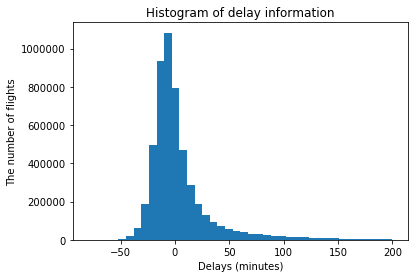

In [44]:
plt.hist (delays, bins=40, range=(-80, 200))
plt.xlabel ('Delays (minutes)')
plt.ylabel ('The number of flights')
plt.title ('Histogram of delay information')
plt.show ()

# Preparing the Data

In [4]:
focused_features = ['MONTH', 'DAY', 'DAY_OF_WEEK', 'AIRLINE', 'FLIGHT_NUMBER', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT', 'SCHEDULED_DEPARTURE',
                    'SCHEDULED_TIME', 'DISTANCE', 'SCHEDULED_ARRIVAL']
features = np.array (df[focused_features[0]]).reshape ((-1, 1))

from sklearn.preprocessing import LabelEncoder

encoded_features = ['AIRLINE', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT']
for name in focused_features[1:] :
    if name in encoded_features :
        enc = LabelEncoder ()
        temp = enc.fit_transform (df[name]).reshape ((-1, 1))
    else :
        temp = np.array (df[name]).reshape ((-1, 1))
    features = np.hstack ([features, temp])

print ('The number of features after one-hot encoding:', features.shape[1])

The number of features after one-hot encoding: 11


In [5]:
from sklearn.model_selection import train_test_split

features_train, features_test, delays_train, delays_test = train_test_split (features, delays, test_size=0.2, random_state=0)

print ('The number of training set:', features_train.shape[0])
print ('The number of testing set:', features_test.shape[0])

The number of training set: 4184904
The number of testing set: 1046226


# Developing a Benchmark Model

In [23]:
avg_delays = np.mean (delays_train)

print ('Average delays:', avg_delays)

Average delays: 4.88476724914


# Developing a Solution Model

In [7]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
import time

print ('Start training KNN Regressor...')
start_time = time.time ()
neigh = KNeighborsRegressor ()
params = { 'n_neighbors': [1, 5, 10, 20, 50, 100] }
clf = GridSearchCV (neigh, params, scoring='neg_mean_absolute_error')
clf.fit (features_train, delays_train)
elapsed_time = time.time() - start_time
print ('Finish training KNN Regressor! Elapsed Ttime =', time.strftime("%H:%M:%S", time.gmtime (elapsed_time)))

Start training KNN Regressor...
Finish training KNN Regressor! Elapsed Ttime = 01:13:48


In [9]:
clf.best_params_['n_neighbors']

100

# Evaluating Model Performance

In [48]:
from sklearn.metrics import mean_absolute_error

delays_pred = [avg_delays for _ in range (len (delays_test))]
naive_score = mean_absolute_error (delays_test, delays_pred)
print ('MAD of Naive algorithm:', naive_score)

delays_pred = clf.predict (features_test)
knn_score = mean_absolute_error (delays_test, delays_pred)
print ('MAD of KNN Regressor:', knn_score)

MAD of Naive algorithm: 21.7003895011
MAD of KNN Regressor: 21.120765284


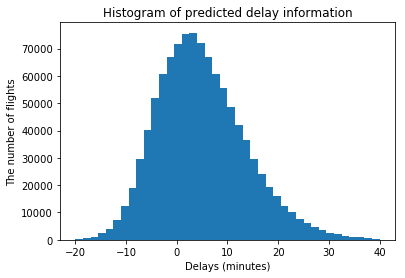

In [60]:
plt.hist (delays_pred, bins=40, range=(-20, 40))
plt.xlabel ('Delays (minutes)')
plt.ylabel ('The number of flights')
plt.title ('Histogram of predicted delay information')
plt.show ()

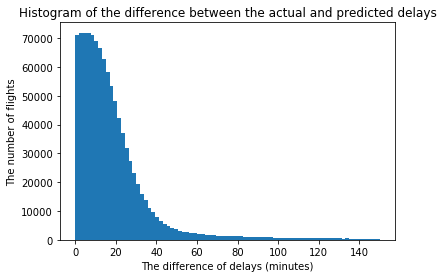

In [59]:
deviation = np.absolute (delays_test - delays_pred)

plt.hist (deviation, bins=80, range=(0, 150))
plt.xlabel ('The difference of delays (minutes)')
plt.ylabel ('The number of flights')
plt.title ('Histogram of the difference between the actual and predicted delays')
plt.show ()